# Deep Learning for Cone Cells and Light Frequency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

np.set_printoptions(suppress=True)

import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras

import pickle

from simulator_lib import *

2025-04-25 00:32:41.357138: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-25 00:32:41.483407: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-25 00:32:41.601284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745555561.707888   13499 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745555561.737999   13499 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 00:32:41.985677: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Generating / Loading the Cone Cells

In [2]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 10
NUM_CELLS_PER_EYE = 10000

NUM_RED = int(NUM_CELLS_PER_EYE * PERCENT_RED)
NUM_GREEN = int(NUM_CELLS_PER_EYE * PERCENT_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * PERCENT_BLUE)
assert(NUM_RED + NUM_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    eyes = []

    for i in range(NUM_EYES):
        RED_MU = np.random.uniform(RED_MU_LOWER, RED_MU_UPPER)
        GREEN_MU = np.random.uniform(GREEN_MU_LOWER, GREEN_MU_UPPER)
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)

        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED, RED_MU, RED_SIGMA) +
            generate_cone_cells(NUM_GREEN, GREEN_MU, GREEN_SIGMA) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA)
        )

        eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/normal_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/normal_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            eyes.append(cone_cells)

## Generating the Simulation Data

In [3]:
NUM_DATA_POINTS = 1000
MIN_WAVELENGTH = 380
MAX_WAVELENGTH = 750

activations = np.zeros(shape=(len(eyes) * NUM_DATA_POINTS, len(eyes[0])))
colors = np.zeros(shape=(len(eyes) * NUM_DATA_POINTS))

for i, cone_cells in enumerate(eyes):
    a, c = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
        min_wl=MIN_WAVELENGTH, 
        max_wl=MAX_WAVELENGTH,
    )
    c = np.array(c).astype(int)

    activations[i * NUM_DATA_POINTS : (i+1) * NUM_DATA_POINTS] = a
    colors[i * NUM_DATA_POINTS : (i+1) * NUM_DATA_POINTS] = c

print(activations)
print(colors)

[[1. 1. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[2. 5. 5. ... 5. 2. 1.]


## Feedforward Network Architecture

### Separate Data into Training and Test Sets

In [4]:
# shuffle the data
#randomize = np.arange(len(activations), dtype=int)
#np.random.shuffle(randomize)
#activations = activations[randomize]
#colors = colors[randomize]

PERCENT_TRAIN_SET = 0.8
NUM_TRAIN_SET = int(len(activations) * PERCENT_TRAIN_SET)

train_activations = activations[:NUM_TRAIN_SET]
train_colors = colors[:NUM_TRAIN_SET]
test_activations = activations[NUM_TRAIN_SET:]
test_colors = colors[NUM_TRAIN_SET:]

### Model Setup

In [5]:
model = keras.Sequential([
    keras.Input(shape=(train_activations.shape[-1], )),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=len(Color), activation="softmax"),
])

2025-04-25 00:33:37.814014: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Compile Model

In [6]:
optimizer = keras.optimizers.AdamW(learning_rate=5e-4, weight_decay=0.004)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,438 (5.08 MB)

 Trainable params: 1,330,438 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

### Fit the Model

In [7]:
EPOCHS = 10
h = model.fit(train_activations, train_colors, batch_size=64, epochs=EPOCHS, validation_split=0.1)

Epoch 1/10


2025-04-25 00:33:42.273508: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 288000000 exceeds 10% of free system memory.


112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7902 - loss: 0.8401

2025-04-25 00:33:47.729232: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32000000 exceeds 10% of free system memory.


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7922 - loss: 0.8332 - val_accuracy: 0.9413 - val_loss: 0.1914
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9632 - loss: 0.1414 - val_accuracy: 0.9538 - val_loss: 0.1122
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9728 - loss: 0.0814 - val_accuracy: 0.9712 - val_loss: 0.0946
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9824 - loss: 0.0609 - val_accuracy: 0.9787 - val_loss: 0.0530
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9847 - loss: 0.0471 - val_accuracy: 0.9850 - val_loss: 0.0330
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9868 - loss: 0.0442 - val_accuracy: 0.9775 - val_loss: 0.0534
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9855 - loss: 0.0446 - val_accuracy: 0.9837 - val_loss: 0.0442
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9902 - loss: 0.0352 - val_accuracy: 0.971

### Visualize Loss Trajectory

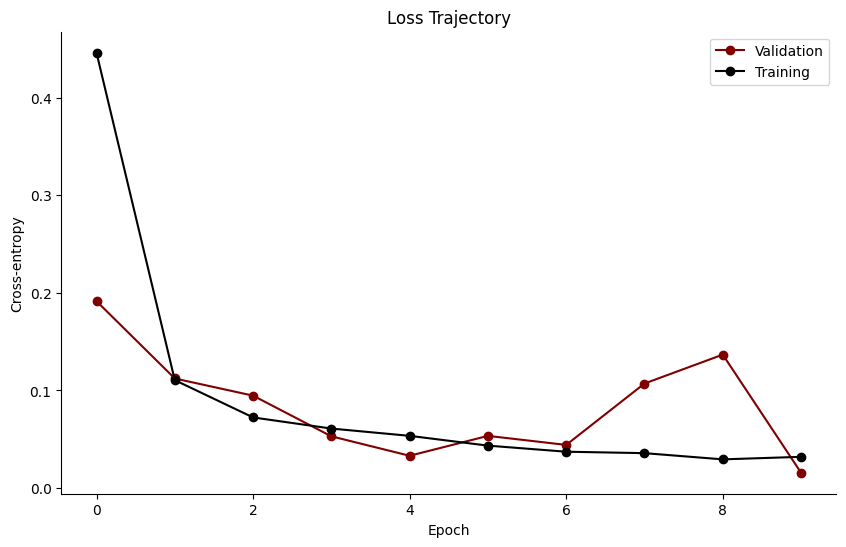

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(EPOCHS), h.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(EPOCHS), h.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

### Evaluate Model on Test Data

In [9]:
test_loss, test_accuracy = model.evaluate(test_activations, test_colors)

21/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7877 - loss: 0.4955

2025-04-25 00:34:34.731422: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80000000 exceeds 10% of free system memory.


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7989 - loss: 0.4801


30/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2025-04-25 00:34:36.472880: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80000000 exceeds 10% of free system memory.


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


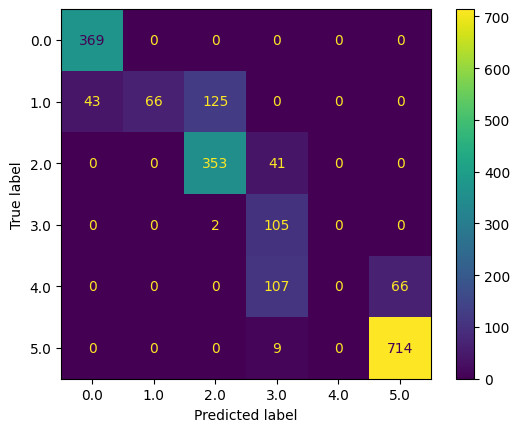

In [10]:
preds = model.predict(test_activations)
metrics.ConfusionMatrixDisplay.from_predictions(test_colors, preds.argmax(axis=1))

## Testing on Data from Abnormal Eyes

### "Damanged" Eyes

"Damaged" eyes have a chance for some cells to be dead and never activate.

#### Generating / Loading the Cone Cells for "Damaged" Eyes

In [34]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 10
PROB_DEAD_CELL_STEP = 0.1

NUM_CELLS_PER_EYE = 10000

NUM_RED = int(NUM_CELLS_PER_EYE * PERCENT_RED)
NUM_GREEN = int(NUM_CELLS_PER_EYE * PERCENT_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * PERCENT_BLUE)
assert(NUM_RED + NUM_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    damaged_eyes = []

    for i in range(NUM_EYES):
        RED_MU = np.random.uniform(RED_MU_LOWER, RED_MU_UPPER)
        GREEN_MU = np.random.uniform(GREEN_MU_LOWER, GREEN_MU_UPPER)
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)
        PROB_DEAD_CELL = i * PROB_DEAD_CELL_STEP

        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED, RED_MU, RED_SIGMA, PROB_DEAD_CELL) +
            generate_cone_cells(NUM_GREEN, GREEN_MU, GREEN_SIGMA, PROB_DEAD_CELL) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA, PROB_DEAD_CELL)
        )

        damaged_eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/damaged_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    damaged_eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/damaged_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            damaged_eyes.append(cone_cells)

#### Testing Model on "Damaged" Eyes

In [27]:
NUM_DATA_POINTS = 100
MIN_WAVELENGTH = 380
MAX_WAVELENGTH = 750

confusion_data = []
accuracies = []

for cone_cells in damaged_eyes:
    activations, colors = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
        min_wl=MIN_WAVELENGTH, 
        max_wl=MAX_WAVELENGTH,
    )
    colors = np.array(colors).astype(int)
    preds = model.predict(activations)
    confusion_data.append((colors, preds))
    _, accuracy = model.evaluate(activations, colors)
    accuracies.append(accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8525 - loss: 0.4253
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8494 - loss: 0.3719 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7469 - loss: 0.6083
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7960 - loss: 0.5586
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7747 - loss: 0.4529
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8125 - loss: 0.6932
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6590 - loss: 0.8949 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4785 - loss: 1.5690 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3726 - loss: 2.2791 
4/4 ━━━━━━

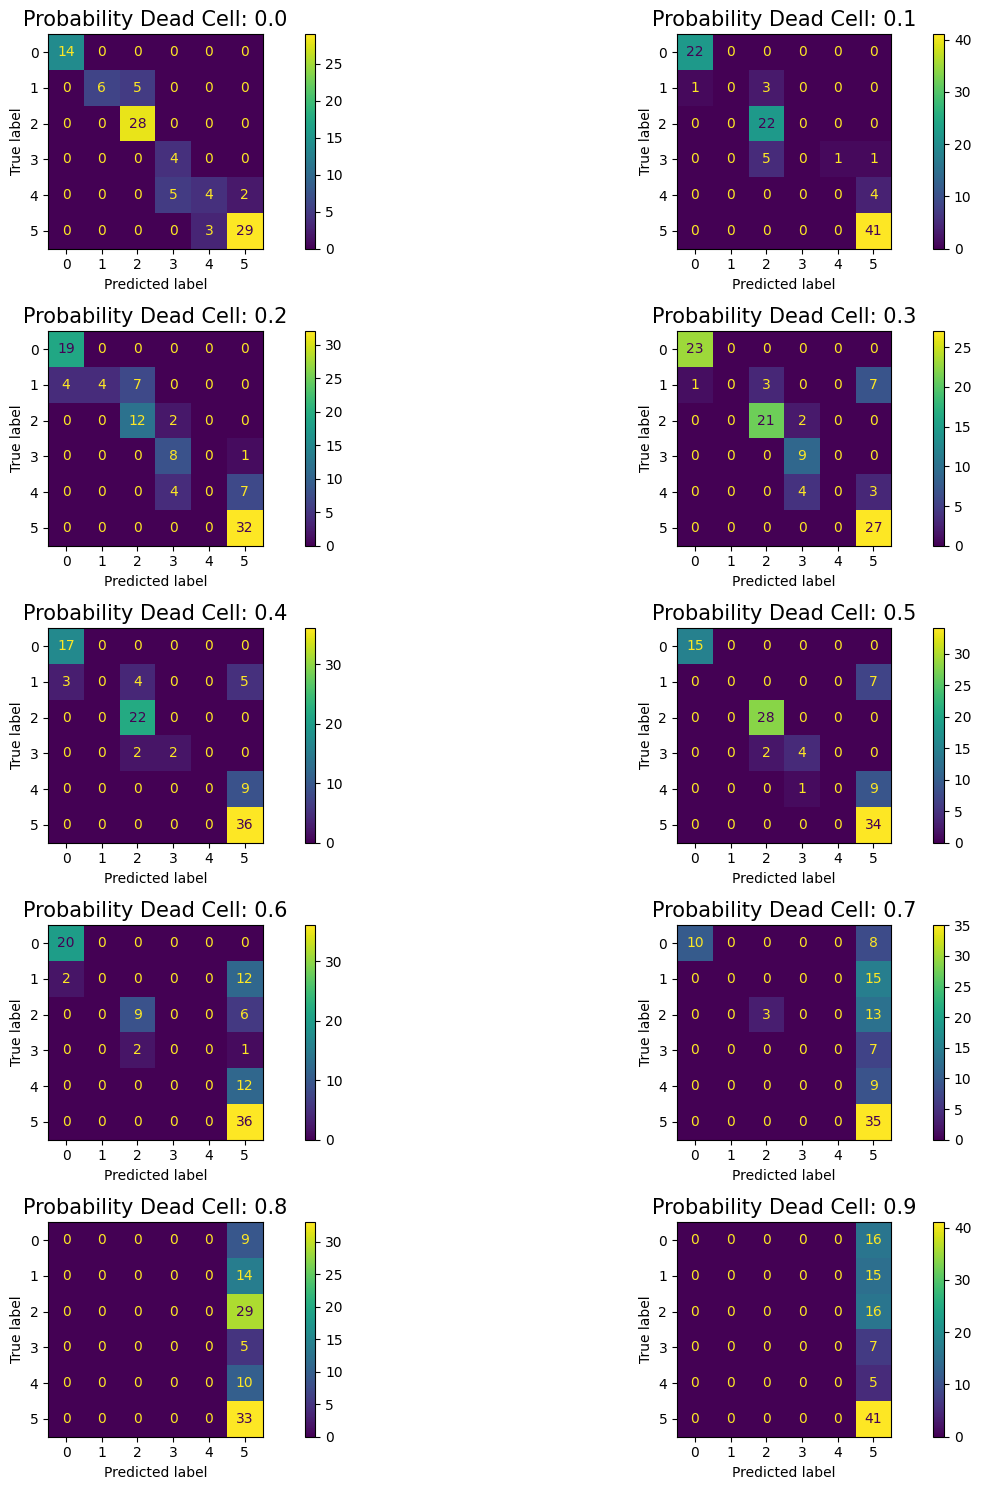

In [ ]:
fig, axarr = plt.subplots(5, 2, figsize=(15,15))
for i, ax in enumerate(axarr.flat):
    colors, preds = confusion_data[i]
    ax.set_title(f"Probability Dead Cell: {PROB_DEAD_CELL_STEP*i:0.1f}", fontsize=15)
    metrics.ConfusionMatrixDisplay.from_predictions(colors, preds.argmax(axis=1), ax=ax)
fig.tight_layout()

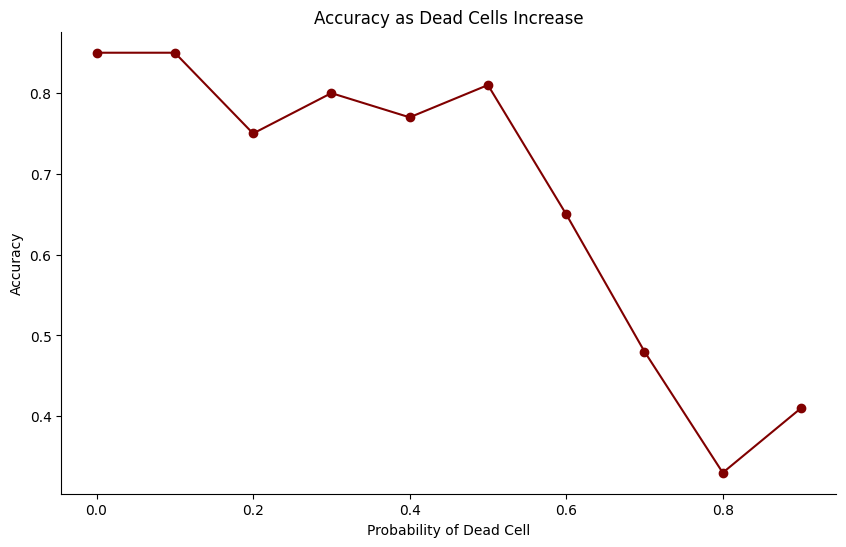

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot([PROB_DEAD_CELL_STEP * i for i in range(NUM_EYES)], accuracies, 'o-', color='maroon')
ax.set_xlabel('Probability of Dead Cell')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as Dead Cells Increase')
sns.despine(ax=ax)

### Colorblind Eyes

Specifically red-green colorblindness

#### Generating / Loading the Cone Cells for Colorblind Eyes

In [21]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 4
NUM_CELLS_PER_EYE = 10000

NUM_RED_GREEN = int(NUM_CELLS_PER_EYE * PERCENT_RED) + int(NUM_CELLS_PER_EYE * PERCENT_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * PERCENT_BLUE)
assert(NUM_RED_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    colorblind_eyes = []

    for i in range(NUM_EYES):
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)
    
        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED_GREEN, RED_GREEN_MU, RED_GREEN_SIGMA) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA)
        )

        colorblind_eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/colorblind_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    colorblind_eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/colorblind_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            colorblind_eyes.append(cone_cells)

#### Testing Model on Colorblind Eyes

In [22]:
NUM_DATA_POINTS = 100
MIN_WAVELENGTH = 380
MAX_WAVELENGTH = 750

confusion_data = []

for cone_cells in colorblind_eyes:
    activations, colors = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
        min_wl=MIN_WAVELENGTH, 
        max_wl=MAX_WAVELENGTH,
    )
    colors = np.array(colors).astype(int)
    preds = model.predict(activations)
    confusion_data.append((colors, preds))
    model.evaluate(activations, colors)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6582 - loss: 1.0355
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4571 - loss: 1.6822
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6032 - loss: 1.0964 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6725 - loss: 1.0657


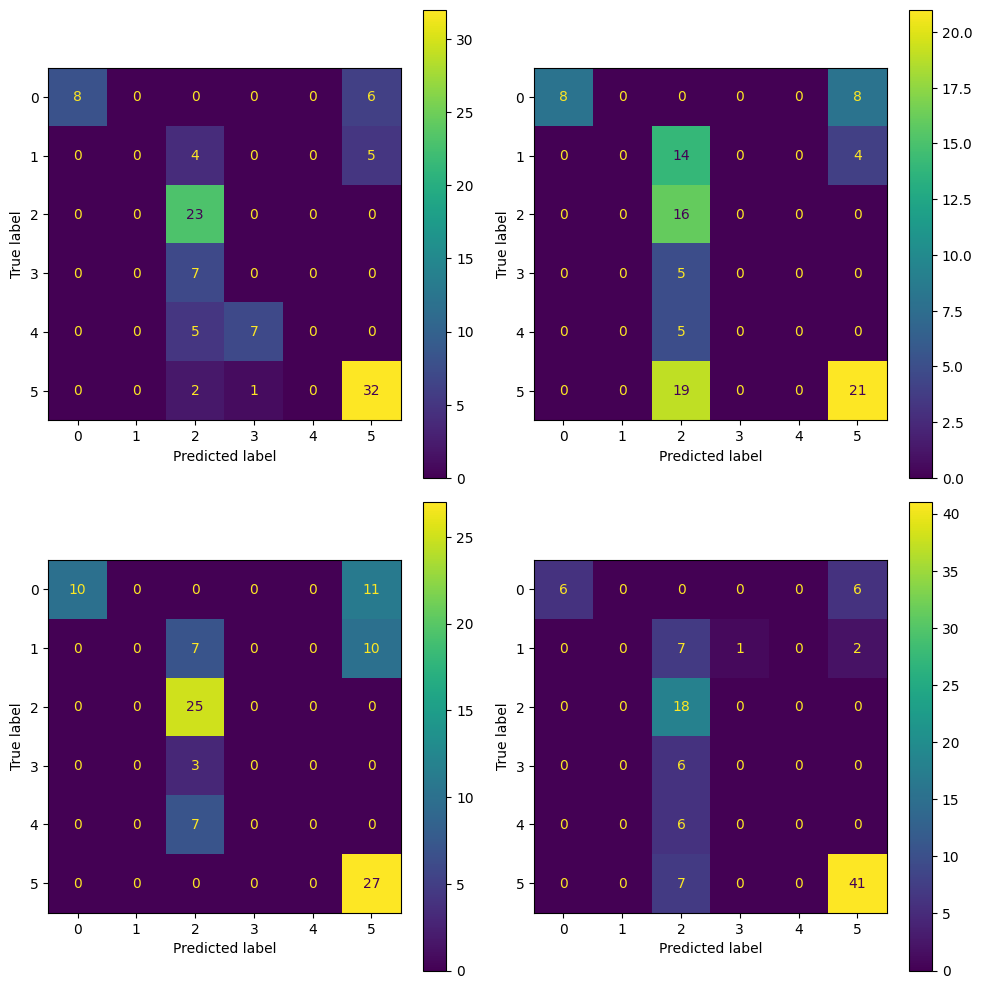

In [25]:
fig, axarr = plt.subplots(2, 2, figsize=(10,10))
for i, ax in enumerate(axarr.flat):
    colors, preds = confusion_data[i]
    metrics.ConfusionMatrixDisplay.from_predictions(colors, preds.argmax(axis=1), ax=ax)
fig.tight_layout()